In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import math
import time

import valez_finite_VI_lib as vi
from data_set_lib import DataSet
import generic_optimization_lib as packing

In [2]:
#np.random.seed(12321)

alpha = 10 # IBP parameter
num_samples = 2000 # Data set size
x_dim = 2 # dimension
sigma_a = 3.0 ** 2
sigma_eps = 0.2 ** 2 # variance of noise
k_inf = 5 # take to be large for a good approximation to the IBP
pi_true, z_true, mu_true, a_true, x = vi.generate_data(num_samples, x_dim, k_inf, sigma_a, sigma_eps, alpha)
k_approx = k_inf

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(num_samples, x_dim, k_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_a, sigma_eps)

data_set = DataSet(x, k_approx, alpha, sigma_eps, sigma_a)

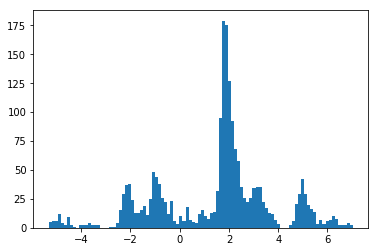

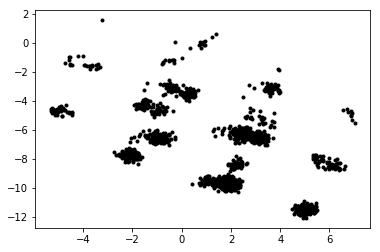

In [3]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [4]:
class GibbsSampler(object):
    def __init__(self, x, k_approx, alpha, sigma_eps, sigma_a):
        self.x = x
        self.x_n = x.shape[0]
        self.x_d = x.shape[1]
        self.k_approx = k_approx
        self.alpha = alpha
        self.sigma_eps = sigma_eps
        self.sigma_a = sigma_a
        
        self.get_z_cond_params = grad(self.z_lp, argnum=0)
        self.get_a_cond_params = grad(self.a_lp, argnum=0)
        self.get_a2_cond_params = grad(self.a_lp, argnum=1)
        self.get_pi1_cond_params = grad(self.pi_lp, argnum=0)
        self.get_pi2_cond_params = grad(self.pi_lp, argnum=1)

        self.initialize_sampler()
        
    def z_lp(self, z):
        return vi.exp_log_likelihood(
            z, self.a, self.a**2, np.log(self.pi), np.log(1 - self.pi),
            self.sigma_a, self.sigma_eps, self.x, self.alpha)

    def pi_lp(self, logpi, log1mpi):
        return vi.exp_log_likelihood(
            self.z, self.a, self.a**2, logpi, log1mpi,
            self.sigma_a, self.sigma_eps, self.x, self.alpha)

    def a_lp(self, a, a2):
        return vi.exp_log_likelihood(
            self.z, a, a2, np.log(self.pi), np.log(1 - self.pi),
            self.sigma_a, self.sigma_eps, self.x, self.alpha)

    def initialize_sampler(self):
        # Initial values for draws
        self.pi = np.ones(k_approx) * .8
        self.z = np.random.binomial(1, self.pi, [ self.x_n, k_approx ]).astype(float, copy=True)
        self.a = np.random.normal(0, np.sqrt(sigma_a), (self.x_d, k_approx))

        self.pi_draws = []
        self.z_draws = []
        self.a_draws = []
        
    def draw_z_column(self, k):
        # Because the z columns are inter-dependent, only draw one column at a time.
        assert k < self.k_approx
        z_cond_params = self.get_z_cond_params(self.z)
        z_logsumexp = sp.misc.logsumexp(z_cond_params, 1)
        z_means = np.exp(z_cond_params - np.broadcast_to(z_logsumexp, (k_approx, num_samples)).T)
        self.z[:, k] = vi.draw_z(z_means, 1)[0, :, k].astype(float)
        
    def draw_a(self):
        a_cond_params = self.get_a_cond_params(self.a, self.a**2)
        a2_cond_params = self.get_a2_cond_params(self.a, self.a**2)

        a_var = -0.5 / a2_cond_params
        a_mean = a_var * a_cond_params
        assert np.all(a_var > 0)

        self.a = vi.draw_a(a_mean, a_var, 1)[0, :, :]

    def draw_pi(self):
        pi1_cond_params = self.get_pi1_cond_params(np.log(self.pi), np.log(1 - self.pi))
        pi2_cond_params = self.get_pi2_cond_params(np.log(self.pi), np.log(1 - self.pi))

        # Note -- add one to get the beta distribution parameters from the gradients.
        pi_params = np.vstack([pi1_cond_params, pi2_cond_params]).T + 1
        self.pi = vi.draw_pi(pi_params, 1)[0, :]
        
        
    def draw(self, keep_draw=False):
        # Draw the z columns in a random order.
        self.draw_a()
        self.draw_pi()
        for z_col in np.random.permutation(self.k_approx):
            self.draw_z_column(z_col)

        if keep_draw:
            self.a_draws.append(self.a)
            self.pi_draws.append(self.pi)
            self.z_draws.append(self.z)
        
    

In [5]:
import progressbar

gibbs_sampler = GibbsSampler(x, k_approx, alpha, sigma_eps, sigma_a)

burnin = 500
num_gibbs_draws = 500
gibbs_sampler.initialize_sampler()

# Start at the truth
gibbs_sampler.z = z_true.astype(float, copy=True)
gibbs_sampler.a = deepcopy(a_true.T)
gibbs_sampler.pi = deepcopy(pi_true)

bar = progressbar.ProgressBar(max_value=num_gibbs_draws + burnin)
for n in range(num_gibbs_draws + burnin):
    gibbs_sampler.draw(keep_draw = n > burnin)
    bar.update(n)
    

print('Done')


 99% (995 of 1000) |###################### | Elapsed Time: 0:00:16 ETA: 0:00:00

Done


[[-2.08859674  3.32857254  2.06068535 -0.0585105  -2.32833502]
 [-4.50780689 -5.8757029  -9.17617382 -6.23655857 -1.45858647]]
[[  3.54092633e-04   1.61533534e-04   3.20272700e-05   1.04585453e-04
    7.61108915e-04]
 [  3.33974098e-04   1.51537239e-04   3.38099422e-05   1.03293669e-04
    7.70214401e-04]]
[[-0.54584699  3.97621322  2.80213717 -1.21368201 -3.15259385]
 [-3.44180974 -1.92066109 -3.0985004  -3.04725435  1.8600719 ]]


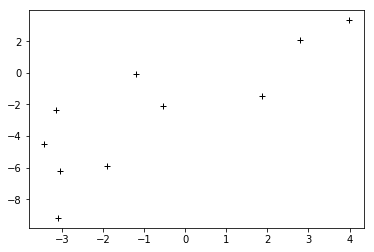

In [9]:

a_mean = np.mean(gibbs_sampler.a_draws, 0)
print(a_mean)
print(np.std(gibbs_sampler.a_draws, 0))
print(a_true.T)

plt.figure()
plt.plot(a_true.T.flatten(), a_mean.flatten(), 'k+')



[ 0.05961047  0.1256097   0.60122689  0.19156855  0.02595573]
[ 0.00548497  0.0076659   0.0108859   0.0089669   0.00350624]
[ 0.8  0.8  0.8  0.8  0.8]


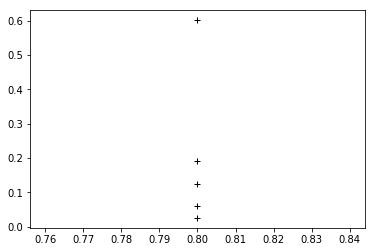

In [10]:
print(np.mean(gibbs_sampler.pi_draws, 0))
print(np.std(gibbs_sampler.pi_draws, 0))
print(pi_true)

plt.figure()
plt.plot(pi_true, np.mean(gibbs_sampler.pi_draws, 0), 'k+')



In [22]:
x_pred_draws = np.einsum('nij,nkj->nik', gibbs_sampler.z_draws, gibbs_sampler.a_draws)
x_pred = np.mean(x_pred_draws, 0)
print(x_pred_draws.shape)
print(gibbs_sampler.x.shape)

(499, 2000, 2)
(2000, 2)


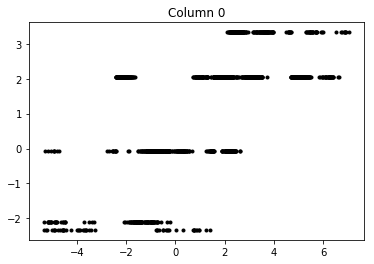

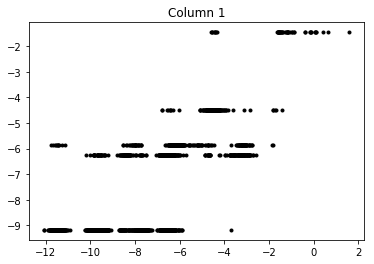

In [25]:

for x_col in range(x_dim):
    plt.figure()
    plt.plot(gibbs_sampler.x[:, x_col], x_pred[:, x_col], 'k.')
    plt.title('Column {}'.format(x_col))